In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import altair as alt; alt.data_transformers.disable_max_rows()
from ipywidgets import interact

import math
import scipy.optimize
from scipy.fftpack import fft, ifft
import torch
import torchaudio
from scipy import signal

In [2]:
train = pd.read_csv('data/train_clean.csv', dtype={'time': np.float32, 'signal': np.float32, 'open_channels':np.int32})
test  = pd.read_csv('data/test_clean.csv',  dtype={'time': np.float32, 'signal': np.float32})
sub   = pd.read_csv('data/sample_submission.csv', dtype={'time': np.float32})

In [3]:
tr0 = train[      0: 500000]
tr1 = train[ 500000:1000000]
tr2 = train[1000000:1500000]
tr3 = train[1500000:2000000]
tr4 = train[2000000:2500000]
tr5 = train[2500000:3000000]
tr6 = train[3000000:3500000]
tr7 = train[3500000:4000000]
tr8 = train[4000000:4500000]
tr9 = train[4500000:5000000]

assert(len(train) == len(tr0)+len(tr1)+len(tr2)+len(tr3)+len(tr4)+len(tr5)+len(tr6)+len(tr7)+len(tr8)+len(tr9))

### OPCION 1: CORREGIR Y para igualarlo a X

Batch: 0 	W: 1.2368 	B: -2.7207 	Diff std: 0.2483 	Diff mean: 0.0
Batch: 1 	W: 1.2375 	B: -2.731 	Diff std: 0.2499 	Diff mean: 0.0
Batch: 2 	W: 1.2341 	B: -2.7362 	Diff std: 0.2479 	Diff mean: -0.0
Batch: 3 	W: 1.231 	B: -2.737 	Diff std: 0.2713 	Diff mean: -0.0
Batch: 4 	W: 1.3083 	B: -5.7941 	Diff std: 0.4258 	Diff mean: -0.198845
Batch: 5 	W: 1.3232 	B: -3.0408 	Diff std: 0.3053 	Diff mean: -0.011092
Batch: 6 	W: 1.2328 	B: -2.733 	Diff std: 0.2478 	Diff mean: 0.0
Batch: 7 	W: 1.2228 	B: -2.7187 	Diff std: 0.662 	Diff mean: 0.0
Batch: 8 	W: 1.326 	B: -3.0657 	Diff std: 0.3033 	Diff mean: -0.009491
Batch: 9 	W: 1.3102 	B: -5.8105 	Diff std: 0.4273 	Diff mean: -0.195591


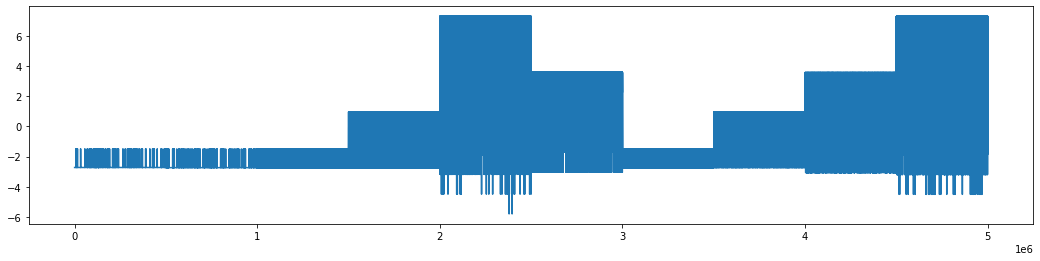

In [4]:
def correct_mae(params):
    w,b = params
    return np.mean(np.abs(x - (y*w + b)))

def correct_mse(params):
    w,b = params
    return np.mean(np.square(x - (y*w + b)))

total_y_corrected = np.array([])
for i,t in enumerate([tr0,tr1,tr2,tr3,tr4,tr5,tr6,tr7,tr8,tr9]):
    x = t["signal"].values
    y = t["open_channels"].values
    res = scipy.optimize.minimize(correct_mse, (0.,0), method='Powell')
    w,b = res.x[0], res.x[1]
    y_corrected = y*w + b
    total_y_corrected = np.append(total_y_corrected, y_corrected)
    print("Batch:",i,"\tW:",round(w,4),"\tB:",round(b,4),"\tDiff std:", round((x - y_corrected).std(),  4),
                                                         "\tDiff mean:",round((x - y_corrected).mean(), 6))
plt.figure(figsize=(18, 4)); plt.plot(total_y_corrected);

### OPCION 2: CORREGIR X para igualarlo a Y

Batch: 0 	W: 0.3498 	B: 0.9696 	Diff std: 0.132 	Diff mean: 0.0
Batch: 1 	W: 0.3854 	B: 1.0726 	Diff std: 0.1395 	Diff mean: 0.0
Batch: 2 	W: 0.6674 	B: 1.9581 	Diff std: 0.1823 	Diff mean: -0.0
Batch: 3 	W: 0.7529 	B: 2.2179 	Diff std: 0.2121 	Diff mean: 0.0
Batch: 4 	W: 0.7689 	B: 4.5654 	Diff std: 0.3254 	Diff mean: 3e-06
Batch: 5 	W: 0.768 	B: 2.2857 	Diff std: 0.2302 	Diff mean: -0.0
Batch: 6 	W: 0.6662 	B: 1.9554 	Diff std: 0.1822 	Diff mean: -0.0
Batch: 7 	W: 0.5562 	B: 2.1952 	Diff std: 0.4465 	Diff mean: -0.0
Batch: 8 	W: 0.7674 	B: 2.2973 	Diff std: 0.2281 	Diff mean: 0.0
Batch: 9 	W: 0.7692 	B: 4.5644 	Diff std: 0.3259 	Diff mean: 1e-06


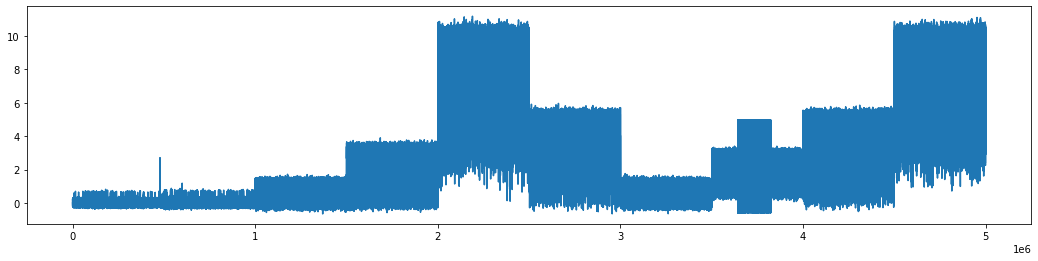

In [5]:
def correct_mae(params):
    w,b = params
    return np.mean(np.abs(y - (x*w + b)))

def correct_mse(params):
    w,b = params
    return np.mean(np.square(y - (x*w + b)))

total_x_corrected = np.array([])
for i,t in enumerate([tr0,tr1,tr2,tr3,tr4,tr5,tr6,tr7,tr8,tr9]):
    x = t["signal"].values
    y = t["open_channels"].values
    res = scipy.optimize.minimize(correct_mse, (1.,0), method='Powell')
    w,b = res.x[0], res.x[1]
    x_corrected = x*w + b
    total_x_corrected = np.append(total_x_corrected, x_corrected)
    print("Batch:",i,"\tW:",round(w,4),"\tB:",round(b,4),"\tDiff std:", round((y - x_corrected).std(),  4),
                                                         "\tDiff mean:",round((y - x_corrected).mean(), 6))
plt.figure(figsize=(18, 4)); plt.plot(total_x_corrected);

### Obetener NOISE con OPCION 2

5000000


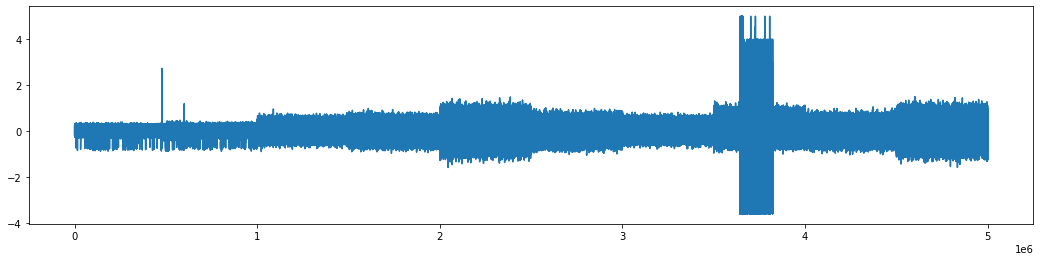

In [6]:
noise = total_x_corrected-train["open_channels"].values
#noise = train["signal"].values - total_y_corrected
print(len(noise))
plt.figure(figsize=(18, 4)); plt.plot(noise);

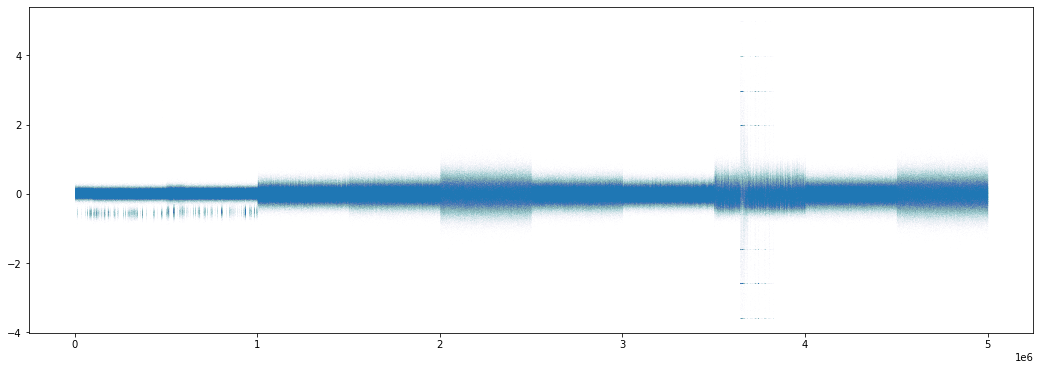

In [7]:
plt.figure(figsize=(18, 6)); plt.scatter(range(5000000),noise, s=0.1, alpha=0.01);

### Ver la media de NOISE para los 50 grupos

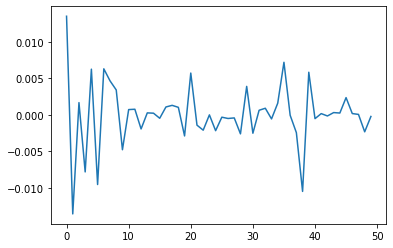

In [8]:
plt.plot([chunck.mean() for chunck in np.split(noise, 50)])

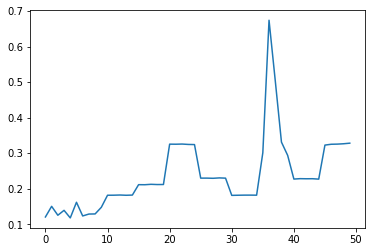

In [9]:
plt.plot([chunck.std() for chunck in np.split(noise, 50)])

### Ver los primero 1000 puntos de NOISE

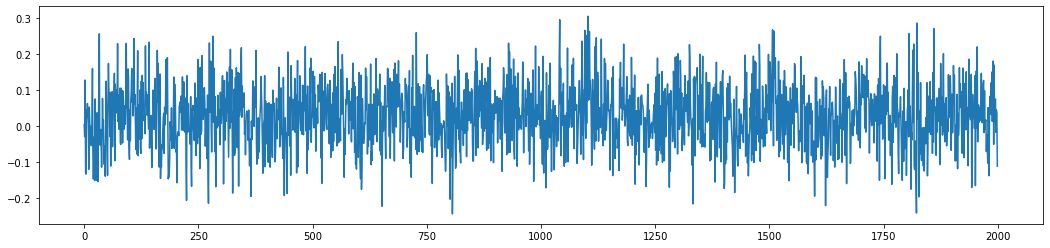

In [10]:
#plt.figure(figsize=(18, 4)); plt.plot(noise[450000:451000]);
plt.figure(figsize=(18, 4)); plt.plot(noise[:2000]);

In [11]:
#N = 31
#noise_31 = scipy.signal.medfilt(noise, kernel_size=N)
#plt.figure(figsize=(18, 4)); plt.plot(noise_11[:2000]);

### Buscar una onda equivalente a los primeros 1000 puntos A MANO

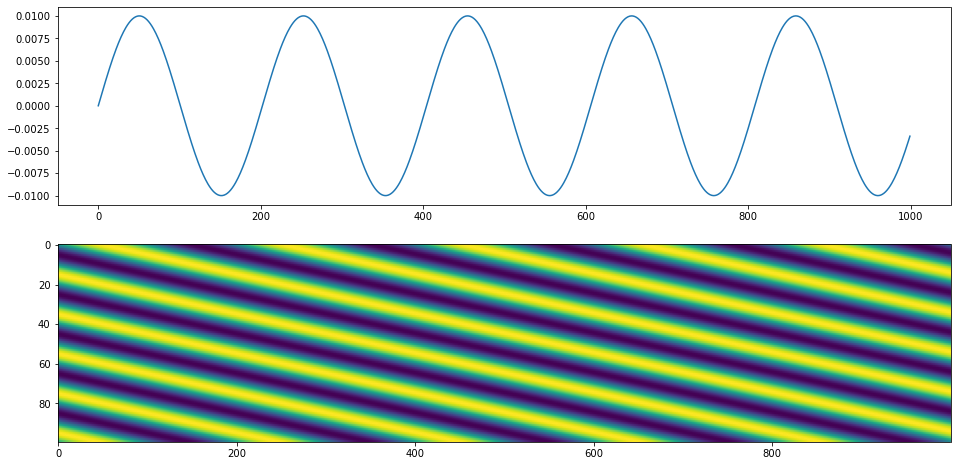

In [15]:
n_points = 100000
freq  = 49.5
ampl  = 0.01
phase = 2

def wave(freq, ampl, phase, n_points):
    #return ampl * np.sin( np.arange(n_points)*freq + phase)
    return ampl * np.sin( np.arange(n_points)* 2 * math.pi / 10000 * freq + phase* math.pi)

my_wave = wave(freq, ampl, phase, n_points)
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))
ax[0].plot(my_wave[:1000]);
ax[1].imshow(my_wave.reshape(-1, 1000), aspect='auto');

### Buscar las 50 onda equivalentes a noise AUTMATICAMENTE con scipy.optimize

Chunck: 1 	freq: 49.913 	ampl: 0.0188 	phase: 1.4172
Chunck: 2 	freq: 50.5 	ampl: 0.01 	phase: 0.6954
Chunck: 3 	freq: 50.1397 	ampl: 0.0192 	phase: 1.0001
Chunck: 4 	freq: 49.9708 	ampl: 0.01 	phase: 1.1544
Chunck: 5 	freq: 49.9461 	ampl: 0.0209 	phase: 0.9
Chunck: 6 	freq: 49.9517 	ampl: 0.0197 	phase: 1.0856
Chunck: 7 	freq: 49.9414 	ampl: 0.0197 	phase: 2.0
Chunck: 8 	freq: 49.9727 	ampl: 0.0201 	phase: 2.0
Chunck: 9 	freq: 50.0359 	ampl: 0.021 	phase: 0.4353
Chunck: 10 	freq: 50.1497 	ampl: 0.01 	phase: 1.0283
Chunck: 11 	freq: 50.0341 	ampl: 0.0102 	phase: 1.0071
Chunck: 12 	freq: 50.0079 	ampl: 0.0217 	phase: 0.8104
Chunck: 13 	freq: 50.0118 	ampl: 0.0129 	phase: 0.0
Chunck: 14 	freq: 50.1652 	ampl: 0.0206 	phase: 1.0416
Chunck: 15 	freq: 49.9382 	ampl: 0.0144 	phase: 1.2886
Chunck: 16 	freq: 50.0508 	ampl: 0.0528 	phase: 0.361
Chunck: 17 	freq: 49.5 	ampl: 0.01 	phase: 1.2666
Chunck: 18 	freq: 49.8698 	ampl: 0.0106 	phase: 0.7602
Chunck: 19 	freq: 50.027 	ampl: 0.0554 	phase: 1

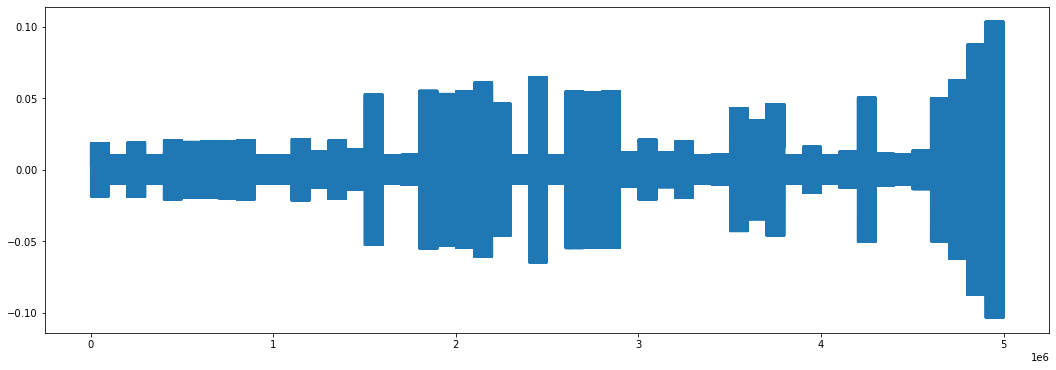

In [15]:
n_chunks   = 50     # 100
chunk_size = 100000 # 50000
assert(n_chunks*chunk_size == len(noise))
       
def wave(freq, ampl, phase, n_points=chunk_size):
    #return ampl * np.sin( np.arange(n_points)*freq + phase)
    return ampl * np.sin( np.arange(n_points)* 2 * math.pi / 10000 * freq + phase* math.pi)

def mae(params):
    freq, ampl, phase = params
    return np.mean(np.abs(noise_chunk - wave(freq, ampl, phase)))

def mse(params):
    freq, ampl, phase = params
    return np.mean(np.square(noise_chunk - wave(freq, ampl, phase)))

all_waves = np.array([])
for i, noise_chunk in enumerate(np.split(noise, n_chunks)):
    limits = ((49.5, 50.5), (0.01, 1.0), (0, 2.0)) # [Freq, ampl, phase] limits
    res = scipy.optimize.minimize(mae, (50, 0.1, 1), method='TNC', bounds=limits)
    freq, ampl, phase = res.x[0], res.x[1], res.x[2]
    all_waves = np.append(all_waves, wave(freq, ampl, phase))
    print("Chunck:",i+1,"\tfreq:",round(freq,4),"\tampl:",round(ampl,4),"\tphase:",round(phase,4))

plt.figure(figsize=(18, 6)); plt.plot(all_waves);

### Comparar

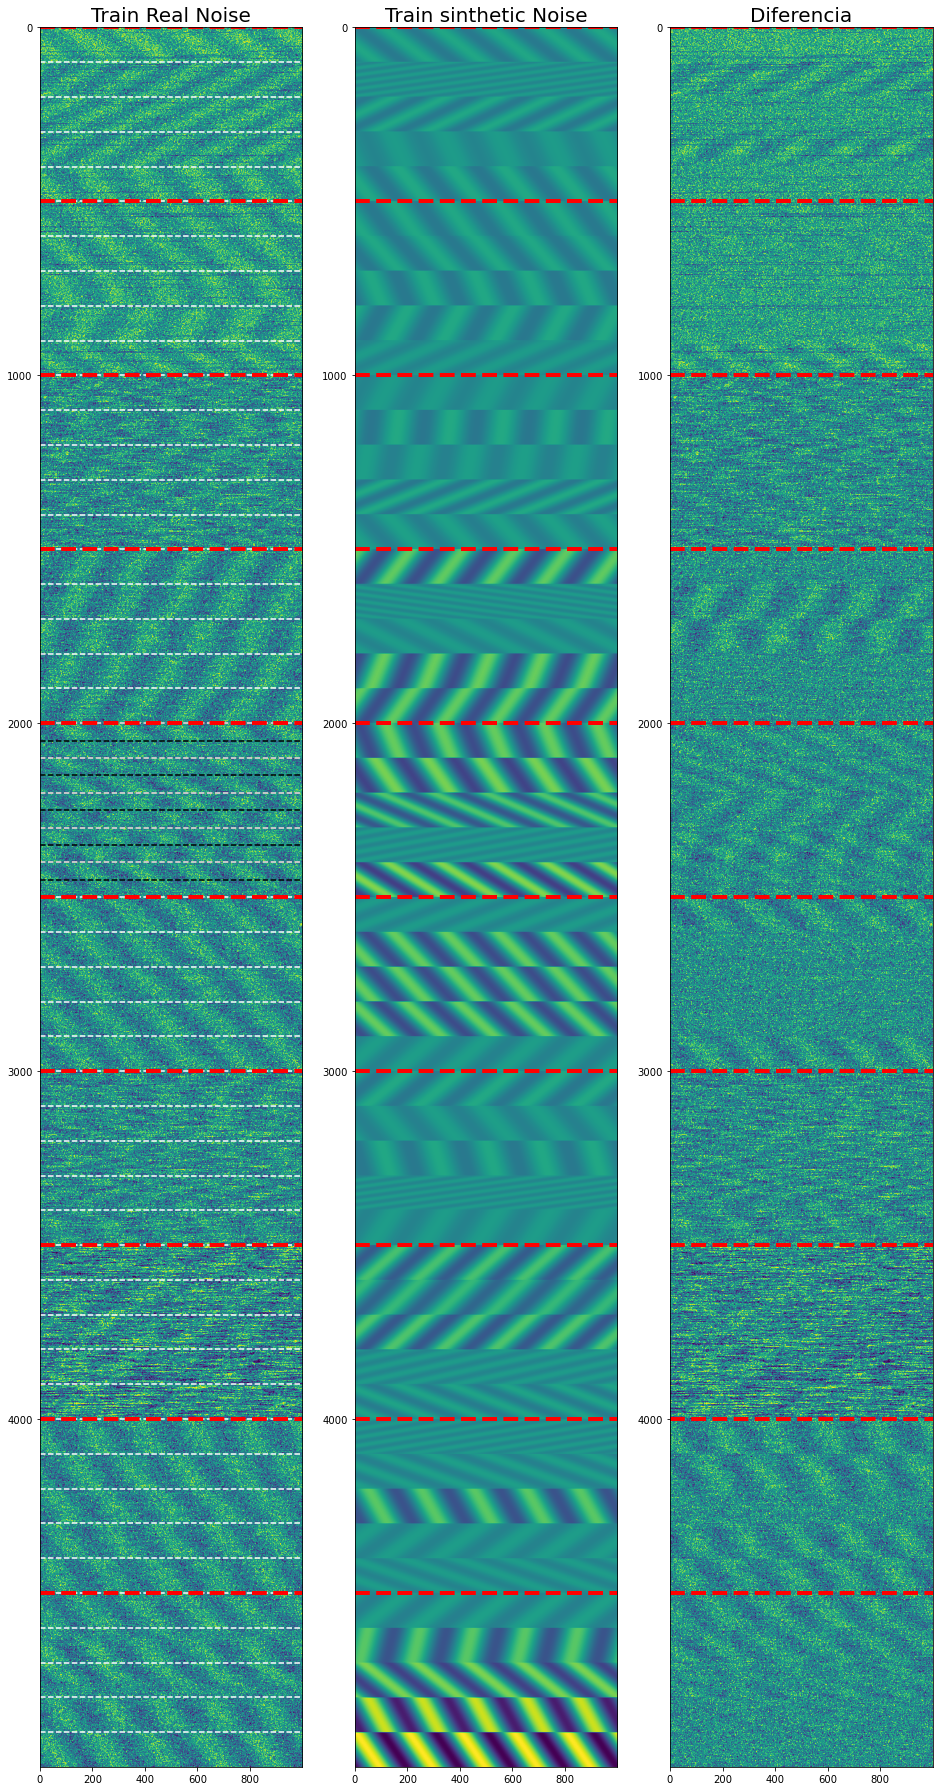

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 32))

ax[0].imshow(noise.reshape(-1, 1000).clip(-0.02,0.02), aspect='auto')
[ax[0].axhline(i, color='k', linestyle='--') for i in range(2000,2500,50)]
[ax[0].axhline(i, color='w', linestyle='--') for i in range(0,5000,100)]
[ax[0].axhline(i, color='r', linestyle='--', linewidth=4) for i in range(0,5000,500)]
ax[0].set_title("Train Real Noise", fontsize=20);

ax[1].imshow(all_waves.reshape(-1, 1000), aspect='auto')
[ax[1].axhline(i, color='r', linestyle='--', linewidth=4) for i in range(0,5000,500)]
ax[1].set_title("Train sinthetic Noise", fontsize=20);

ax[2].imshow((noise-all_waves).reshape(-1, 1000).clip(-0.02,0.02), aspect='auto')
[ax[2].axhline(i, color='r', linestyle='--', linewidth=4) for i in range(0,5000,500)]
ax[2].set_title("Diferencia", fontsize=20);